In [5]:
# ---------- Install the dependencies ----------

#!pip install gym
#!pip install gym[atari]

In [6]:
# ---------- Libraries ----------

#!pip install dill

import sys
sys.path.append('../')  # Enable importing from `src` folder

%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer

def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [7]:
import importlib
importlib.reload(aux_plots)

<module 'src.aux_plots' from '/home/aline/Documents/GitHub/FreewayGame/aline.almeida/src/aux_plots.py'>

In [8]:
# ---------- RAM mask for the selected features ----------

RAM_mask = [
      14  # The chicken Y-position value
    , 16  # Indicates if there was a collision
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Indicate the cars X-coordinates in each lane.
]

In [9]:
# ---------- Restricting the chicken's field of view ----------

def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position 
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 19 or ob[b] > 79:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space 
            ob[b] = ob[b] // 3

    return ob

In [10]:
# ---------- Gym Freeway-ram-v4 environment ----------

env, initial_state = environment.get_env()

print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Action Space: Discrete(3)
Observation Space: Box(0, 255, (128,), uint8)


In [11]:
# ---------- Rewards ----------

def reward_policy(reward, ob, action):
    if reward == 1:    # Cross all the lanes
        reward = reward_policy.REWARD_IF_CROSS
    
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
       
    elif action == 0:  # don't move (still)
        reward = reward_policy.REWARD_IF_STILL
        
    elif action == 1:  # Move ahead (up)
        reward = reward_policy.REWARD_IF_FW
    
    elif action == 2:  # Move back (down)
        reward = reward_policy.REWARD_IF_BW

    return reward

In [12]:
# ---------- Running the baseline agent ----------

# baseline_scores = environment.run(agents.Baseline, render=False, n_runs=100, verbose=False)
#
# with open("baseline_scores.txt", "w") as f:
#     for item in baseline_scores:
#         f.write("%s\n" % item)

In [13]:
with open("baseline_scores.txt") as f:
    baseline_scores = [int(x) for x in  f.read().splitlines()]

In [14]:
# Mean score of the baseline agent
baseline_mean_score = sum(baseline_scores) / len(baseline_scores) 
print("Baseline mean score:", baseline_mean_score)

Baseline mean score: 21.48


# QL (R3) gifs

In [23]:
from matplotlib import animation
# From https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def _save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [35]:
def generate_gif(fn: str, agent):
    env, initial_state = environment.get_env()
    game_over = False
    state = reduce_state(initial_state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)

    frames = []
    FRAME_FREQ = 2

    for t in range(1000):
        if t % FRAME_FREQ == 0:
            frames.append(env.render(mode="rgb_array"))

        ob, _, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        state = ob[RAM_mask].data.tobytes()
        action = agent.act(state)  # Next action

        if game_over:
            break

    _save_frames_as_gif(frames=frames, path='', filename=f'{fn}.gif')

**QL (R3) gifs - 500 steps**

In [36]:
model_500 = "_2020_12_25_19_55_18.dill"

ql_500 = serializer.Experiment.load_experiment("QL/serialized_models/"+str(model_500))
agent_500 = ql_500.agent
scores_ql = ql_500.scores
total_rewards_ql = ql_500.total_rewards

CPU times: user 5.51 s, sys: 41 ms, total: 5.55 s
Wall time: 41 s


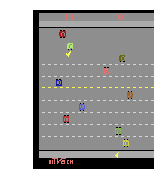

In [37]:
%%time
generate_gif('QL-R3_500', agent_500)

---

**QL (R3) gifs - 1000 steps**

In [39]:
model_1000 = "_2020_12_25_20_16_30.dill"

ql_1000 = serializer.Experiment.load_experiment("QL/serialized_models/"+str(model_1000))
agent_1000 = ql_1000.agent
scores_ql = ql_1000.scores
total_rewards_ql = ql_1000.total_rewards

CPU times: user 5.96 s, sys: 63.5 ms, total: 6.03 s
Wall time: 37.1 s


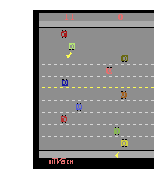

In [40]:
%%time
generate_gif('QL-R3_1000', agent_1000)

---

**QL (R3) gifs - 2000 steps**

In [41]:
model_2000 = "_2020_12_25_20_59_01.dill"

ql_2000 = serializer.Experiment.load_experiment("QL/serialized_models/"+str(model_2000))
agent_2000 = ql_2000.agent
scores_ql = ql_2000.scores
total_rewards_ql = ql_2000.total_rewards

CPU times: user 5.31 s, sys: 45.4 ms, total: 5.36 s
Wall time: 36.2 s


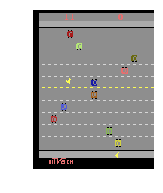

In [42]:
%%time
generate_gif('QL-R3_2000', agent_2000)

---

**QL (R3) gifs - 4000 steps**

In [43]:
model_4000 = "_2020_12_25_22_24_07.dill"

ql_4000 = serializer.Experiment.load_experiment("QL/serialized_models/"+str(model_4000))
agent_4000 = ql_4000.agent
scores_ql = ql_4000.scores
total_rewards_ql = ql_4000.total_rewards

CPU times: user 5.32 s, sys: 90.1 ms, total: 5.41 s
Wall time: 35.1 s


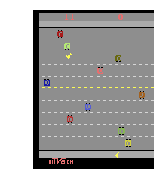

In [44]:
%%time
generate_gif('QL-R3_4000', agent_4000)

**QL (R3) gifs - 9500 steps**

In [45]:
model_9500 = "_2020_12_26_02_18_19.dill"

ql_9500 = serializer.Experiment.load_experiment("QL/serialized_models/R3/"+str(model_9500))
agent_9500 = ql_9500.agent
scores_ql = ql_9500.scores
total_rewards_ql = ql_9500.total_rewards

In [ ]:
%%time
generate_gif('QL-R3_9500', agent_9500)

# QL (R2) gifs